# Pre-requisites  
- download dataset.zip,  
- unzip dataset,    
- mount drive,  

In [107]:
# Package installations
from IPython.utils import io
with io.capture_output() as captured:
    !pip install gdown
    # Install neptune.ai client for monitoring the training process
    !pip install neptune-client
    !pip install neptune-client neptune-tensorboard
    !pip install neptune-contrib
    !pip install imgaug==0.2.6
    !pip install --upgrade Pillow

In [108]:
!pip install --upgrade Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)


In [109]:
!pip install --upgrade torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [110]:
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-npyoiofk
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-npyoiofk
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2774233 sha256=4db7cb261febde37456f73ab02373fd23084de51bd913121216c8b881265a6b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ydsnzk3g/wheels/81/ac/ed/09f1890b954ca1ff7f189518cc9a319138e50e7ea88937fae9
Successfully built pydensecrf


In [111]:
%cd /content/
# Download VOC2012
# !gdown https://drive.google.com/uc?id=1PDTEuTnWJZNWogxYdqYGOlEZHK8dYET9

# Download custom Kvasir-v2
# ! gdown https://drive.google.com/uc?id=1WG5F7VVQe6mNupR1LLirkG_Apx6Bup5J

/content


In [112]:
# with io.capture_output() as captured:
#   # !unzip -q VOC2012.zip
#   !unzip -q Kvasir-v2.zip
#   # !rm -rf VOC2012.zip
#   !rm -rf Kvasir-v2.zip

In [113]:
from IPython.utils import io
with io.capture_output() as captured:
  from google.colab import drive 
  drive.mount('/content/drive')
%cd /content/drive/MyDrive/MAI/thesis/source

/content/drive/MyDrive/MAI/thesis/source


# Imports

In [114]:
import numpy as np
import sys
sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA')
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import PIL.Image
import os.path
import scipy.misc
from utils import imutils
from torchvision import transforms
import cv2
import pandas as pd
import random, tqdm
import albumentations as album

IMG_FOLDER_NAME = "polyps/"
ANNOT_FOLDER_NAME = "polyps/masks"

CAT_LIST = ['dyed-lifted-polyp',
            'dyed-resection-margins',
            'esophagitis',
            'normal-cecum',
            'normal-pylorus',
            'normal-z-line', 
            'polyps',
            'ulcerative-colitis']

CAT_NAME_TO_NUM = dict(zip(CAT_LIST,range(len(CAT_LIST))))


def load_image_label_list_from_npy(img_name_list):
    cls_labels_dict = np.load('kvasirv2/cls_labels.npy', allow_pickle=True).item()
    # print(cls_labels_dict)
    return [cls_labels_dict[img_name] for img_name in img_name_list]

def get_img_path(img_name, dataset_root):
    return os.path.join(dataset_root, img_name)

def load_img_name_list(dataset_path):
    img_gt_name_list = open(dataset_path).read().splitlines()
    img_name_list = [img_gt_name.split(' ')[0][-40:-4] for img_gt_name in img_gt_name_list]
    folder_paths_list = [img_gt_name.split(' ')[0] for img_gt_name in img_gt_name_list]
    return img_name_list, folder_paths_list

def load_label_list(dataset_path):
    zero_array = np.zeros(8, dtype=np.float32)
    list_of_arrays = []
    for i in range(8):
        z = np.zeros(8, dtype=np.float32)
        z[i]=1.0
        list_of_arrays.append(z)
    #print(list_of_arrays)
    img_name_list = open(dataset_path).read().splitlines()
    label_list = [list_of_arrays[int(img_name[-1:])-1] for img_name in img_name_list]
    return label_list

class KvasirImageDataset(Dataset):
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        self.img_name_list, self.folder_paths_list = load_img_name_list(img_name_list_path)
        self.dataset_root = dataset_root
        self.transform = transform

    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        name = self.img_name_list[idx]
        path = self.folder_paths_list[idx]
        # print(get_img_path(path, self.dataset_root))
        img = PIL.Image.open(get_img_path(path, self.dataset_root)).convert("RGB")
        # img = torch.from_numpy(np.array(img))

        if self.transform:
            img = self.transform(img)

        return name, img


class KvasirClsDataset(KvasirImageDataset):           # inherit init from previous class
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        super().__init__(img_name_list_path, dataset_root, transform)
        self.label_list = load_image_label_list_from_npy(self.img_name_list)        # get list from .npy file
        #self.label_list = load_image_label_list_from_xml(self.img_name_list, self.dataset_root)

    def __getitem__(self, idx):
        name, img = super().__getitem__(idx)

        label = torch.from_numpy(self.label_list[idx])

        return name, img, label

class KvasirClsDatasetMSF(KvasirClsDataset):
    def __init__(self, img_name_list_path, data_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, data_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)

        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))

        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        msf_img_list = []
        for i in range(len(ms_img_list)):
            msf_img_list.append(ms_img_list[i])
            msf_img_list.append(np.flip(ms_img_list[i], -1).copy())

        return name, msf_img_list, label

class KvasirClsDatasetMS(KvasirClsDataset):
    def __init__(self, img_name_list_path, dataset_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, dataset_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)

        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))

        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        return name, ms_img_list, label

# SEG infer
Imports

Change directory to OAA-PyTorch




In [115]:
%cd OAA/

/content/drive/MyDrive/MAI/thesis/source/OAA


In [116]:
import imageio
import sys
sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA')

import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from utils.LoadData import test_data_loader
from utils.Restore import restore
import matplotlib.pyplot as plt
from models import vgg
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import utils.imutils as imutils
import kvasirv2.data

import torch
import torchvision
from utils import imutils

import argparse
import importlib
import numpy as np

import voc12.data
from torch.utils.data import DataLoader
import scipy.misc
import torch.nn.functional as F
import os.path

colormaps = ['#000000', '#7F0000', '#007F00', '#7F7F00', '#00007F', '#7F007F', '#007F7F', '#7F7F7F', '#3F0000', '#BF0000', '#3F7F00',
                      '#BF7F00', '#3F007F', '#BF007F', '#3F7F7F', '#BF7F7F', '#003F00', '#7F3F00', '#00BF00', '#7FBF00', '#003F7F']


# Parameters

In [117]:
# # For Kvasir v2
# data_root = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2' 
# save_dir = './results_kvasir/exp4/attention/'
# img_dir = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2'
# infer_list = './kvasirv2/train.txt'
# batch_size = 32
# input_size = 256
# dataset = 'kvasir'
# num_classes = 8
# num_workers = 2
# restore_from = './checkpoints/train/exp4/kvasir_epoch_13.pth'
# out_cam = './results_kvasir/exp4/results_cam/'
# out_crf = './results_kvasir/exp4/results_crf/'
# out_cam_pred_alpha = 0.26
# crop_size = 224
# out_cam_pred = "./results_kvasir/exp4/results_cam_pred/"

In [118]:
# For VOC
data_root = '/content/drive/MyDrive/MAI/thesis/source/VOCdevkit/VOC2012' 
out_rw = './results_voc/exp2/results_seg/'
infer_list = './voc12/train.txt'
batch_size = 8
input_size = 256
dataset = 'voc'

num_classes = 20
num_workers = 2

weights = '/content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train_aff/exp2/voc_epoch_7.pth'
cam_dir = '/content/drive/MyDrive/MAI/thesis/source/OAA/results_voc/exp2/results_cam'
out_crf = '/content/drive/MyDrive/MAI/thesis/source/OAA/results_voc/exp2/results_crf'
out_cam_pred_alpha = 0.26
crop_size = 224

alpha = 4
beta = 24
crf = True
logt = 6

network = "network.resnet38_aff"

In [119]:
!pwd

/content/drive/MyDrive/MAI/thesis/source/OAA


# functions

In [120]:
def get_indices_in_radius(height, width, radius):
    search_dist = []
    for x in range(1, radius):
        search_dist.append((0, x))

    for y in range(1, radius):
        for x in range(-radius+1, radius):
            if x*x + y*y < radius*radius:
                search_dist.append((y, x))

    full_indices = np.reshape(np.arange(0, height * width, dtype=np.int64),
                              (height, width))
    radius_floor = radius-1
    cropped_height = height - radius_floor
    cropped_width = width - 2 * radius_floor
    indices_from = np.reshape(full_indices[:-radius_floor, radius_floor:-radius_floor], [-1])

    indices_from_to_list = []

    for dy, dx in search_dist:
        indices_to = full_indices[dy:dy + cropped_height, radius_floor + dx:radius_floor + dx + cropped_width]
        indices_to = np.reshape(indices_to, [-1])
        indices_from_to = np.stack((indices_from, indices_to), axis=1)
        indices_from_to_list.append(indices_from_to)

    concat_indices_from_to = np.concatenate(indices_from_to_list, axis=0)

    return concat_indices_from_to

In [121]:
def colormap(index):
    return mpl.colors.LinearSegmentedColormap.from_list('cmap', [colormaps[0], colormaps[index+1], '#FFFFFF'], 256)

def _crf_with_alpha(orig_img, cam_dict, alpha):
    v = np.array(list(cam_dict.values()))       # change dict to array
    bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
    bgcam_score = np.concatenate((bg_score, v), axis=0)
    crf_score = imutils.crf_inference(np.ascontiguousarray(orig_img.astype(np.uint8)), bgcam_score, labels=bgcam_score.shape[0])

    n_crf_al = dict()

    n_crf_al[0] = crf_score[0]
    for i, key in enumerate(cam_dict.keys()):
        n_crf_al[key+1] = crf_score[i+1]

    return n_crf_al

def worker_init_fn(worker_id):
      np.random.seed(1 + worker_id)

In [122]:
def validate():
  print('\nvalidating ... ', flush=True, end='')
  alpha = 4
  beta = 24
  crf = True
  logt = 6

  mean_vals = [0.485, 0.485, 0.485]              # for standardization
  std_vals = [0.335, 0.335, 0.335]

  # Get model
  model = getattr(importlib.import_module(network), 'Net')()
  model.load_state_dict(torch.load(weights), strict=False)
  model.eval()
  model.cuda()

  infer_dataset = voc12.data.VOC12ImageDataset(infer_list, voc12_root=data_root,
                                               transform=torchvision.transforms.Compose(
        [np.asarray,
         model.normalize,
         imutils.HWC_to_CHW]))
  infer_data_loader = DataLoader(infer_dataset, shuffle=False, num_workers=num_workers, pin_memory=True)

  for iter, (name, img) in enumerate(infer_data_loader):
      name = name[0]
      print(name, name[0])
      print(iter)

      orig_shape = img.shape
      padded_size = (int(np.ceil(img.shape[2]/8)*8), int(np.ceil(img.shape[3]/8)*8))

      p2d = (0, padded_size[1] - img.shape[3], 0, padded_size[0] - img.shape[2])
      img = F.pad(img, p2d)

      plt.imshow(img)
      plt.figure()

      dheight = int(np.ceil(img.shape[2]/8))
      dwidth = int(np.ceil(img.shape[3]/8))

      cam = np.load(os.path.join(cam_dir, name + '.npy'), allow_pickle=True).item() # load the stored cam dict
      print(cam.shape)
      plt.imshow(cam)
      cam_full_arr = np.zeros((21, orig_shape[2], orig_shape[3]), np.float32)       # init array

      for k, v in cam.items():          # for key and value store values
          cam_full_arr[k+1] = v
      cam_full_arr[0] = (1 - np.max(cam_full_arr[1:], (0), keepdims=False))**alpha                  # mult by alpha
      #cam_full_arr[0] = 0.2
      cam_full_arr = np.pad(cam_full_arr, ((0, 0), (0, p2d[3]), (0, p2d[1])), mode='constant')      # pad the array
      
      with torch.no_grad():       # don't compute the gradients
          aff_mat = torch.pow(model.forward(img.cuda(), True), beta)      # find the output of the model and power it up to beta
          trans_mat = aff_mat / torch.sum(aff_mat, dim=0, keepdim=True)   # normalize the output
          # perform torch multiplication logt times 
          for _ in range(logt):
              trans_mat = torch.matmul(trans_mat, trans_mat)

          cam_full_arr = torch.from_numpy(cam_full_arr)           # convert to torch
          cam_full_arr = F.avg_pool2d(cam_full_arr, 8, 8)         # avg pool
          cam_vec = cam_full_arr.view(21, -1)

          cam_rw = torch.matmul(cam_vec.cuda(), trans_mat)
          cam_rw = cam_rw.view(1, 21, dheight, dwidth)            # reshape
      
          cam_rw = torch.nn.Upsample((img.shape[2], img.shape[3]), mode='bilinear')(cam_rw)

          if crf:    
              img_8 = img[0].numpy().transpose((1,2,0))#F.interpolate(img, (dheight,dwidth), mode='bilinear')[0].numpy().transpose((1,2,0))
              img_8 = np.ascontiguousarray(img_8)
              mean = (0.485, 0.456, 0.406)
              std = (0.229, 0.224, 0.225)
              img_8[:,:,0] = (img_8[:,:,0]*std[0] + mean[0])*255
              img_8[:,:,1] = (img_8[:,:,1]*std[1] + mean[1])*255
              img_8[:,:,2] = (img_8[:,:,2]*std[2] + mean[2])*255
              img_8[img_8 > 255] = 255
              img_8[img_8 < 0] = 0
              img_8 = img_8.astype(np.uint8)
              cam_rw = cam_rw[0].cpu().numpy()
              cam_rw = imutils.crf_inference(img_8, cam_rw, t=1)
              cam_rw = torch.from_numpy(cam_rw).view(1, 21, img.shape[2], img.shape[3]).cuda()

          _, cam_rw_pred = torch.max(cam_rw, 1)

          res = np.uint8(cam_rw_pred.cpu().data[0])[:orig_shape[2], :orig_shape[3]]
          scipy.misc.imsave(os.path.join(out_rw, name + '.png'), res)
          break



In [238]:
print('\nvalidating ... \n', flush=True, end='')
alpha = 4
beta = 8
crf = True
logt = 6

mean_vals = [0.485, 0.485, 0.485]              # for standardization
std_vals = [0.335, 0.335, 0.335]

# Get model
model = getattr(importlib.import_module(network), 'Net')()
model.load_state_dict(torch.load(weights), strict=False)
model.eval()
model.cuda()

infer_dataset = voc12.data.VOC12ImageDataset(infer_list, voc12_root=data_root,
                                              transform=torchvision.transforms.Compose(
      [np.asarray,
        model.normalize,
        imutils.HWC_to_CHW]))
infer_data_loader = DataLoader(infer_dataset, shuffle=False, num_workers=num_workers, pin_memory=True)

for iter, (name, img) in enumerate(infer_data_loader):
    name = name[0]

    orig_shape = img.shape
    padded_size = (int(np.ceil(img.shape[2]/8)*8), int(np.ceil(img.shape[3]/8)*8))

    p2d = (0, padded_size[1] - img.shape[3], 0, padded_size[0] - img.shape[2])
    img = F.pad(img, p2d)

    dheight = int(np.ceil(img.shape[2]/8))
    dwidth = int(np.ceil(img.shape[3]/8))

    cam = np.load(os.path.join(cam_dir, name + '.npy'), allow_pickle=True).item() # load the stored cam dict
    cam_full_arr = np.zeros((21, orig_shape[2], orig_shape[3]), np.float32)       # init array

    for k, v in cam.items():          # for key and value store values
        cam_full_arr[k+1] = v
    cam_full_arr[0] = (1 - np.max(cam_full_arr[1:], (0), keepdims=False))**alpha                  # to the power of alpha
    cam_full_arr[0] = (np.max(cam_full_arr[1:], (0), keepdims=False))**alpha                  # to the power of alpha

    cam_full_arr = np.pad(cam_full_arr, ((0, 0), (0, p2d[3]), (0, p2d[1])), mode='constant')      # pad the array
    print(cam_full_arr.shape, cam_full_arr.max(), cam_full_arr.min())
    
    with torch.no_grad():       # don't compute the gradients
        aff_mat = torch.pow(model.forward(img.cuda(), True), beta)      # find the output of the model and power it up to beta
        print('aff mat shape: ', aff_mat.shape)

        trans_mat = aff_mat / torch.sum(aff_mat, dim=0, keepdim=True)   # normalize the output
        print('trans mat shape: ', trans_mat.shape)
        # perform torch multiplication logt times 
        for _ in range(logt):
            trans_mat = torch.matmul(trans_mat, trans_mat)

        cam_full_arr = torch.from_numpy(cam_full_arr)           # convert to torch
        cam_full_arr = F.avg_pool2d(cam_full_arr, 8, 8)         # avg pool
        cam_vec = cam_full_arr.view(21, -1)

        cam_rw = torch.matmul(cam_vec.cuda(), trans_mat)
        cam_rw = cam_rw.view(1, 21, dheight, dwidth)            # reshape
    
        cam_rw = torch.nn.Upsample((img.shape[2], img.shape[3]), mode='bilinear')(cam_rw)

        if crf:    
            img_8 = img[0].numpy().transpose((1,2,0))#F.interpolate(img, (dheight,dwidth), mode='bilinear')[0].numpy().transpose((1,2,0))
            img_8 = np.ascontiguousarray(img_8)
            mean = (0.485, 0.456, 0.406)
            std = (0.229, 0.224, 0.225)
            img_8[:,:,0] = (img_8[:,:,0]*std[0] + mean[0])*255
            img_8[:,:,1] = (img_8[:,:,1]*std[1] + mean[1])*255
            img_8[:,:,2] = (img_8[:,:,2]*std[2] + mean[2])*255
            img_8[img_8 > 255] = 255
            img_8[img_8 < 0] = 0
            img_8 = img_8.astype(np.uint8)
            cam_rw = cam_rw[0].cpu().numpy()
            cam_rw = imutils.crf_inference(img_8, cam_rw, t=1)
            cam_rw = torch.from_numpy(cam_rw).view(1, 21, img.shape[2], img.shape[3]).cuda()

        _, cam_rw_pred = torch.max(cam_rw, 1)

        res = np.uint8(cam_rw_pred.cpu().data[0])[:orig_shape[2], :orig_shape[3]]
        # scipy.misc.imsave(os.path.join(out_rw, name + '.png'), res)
        break




validating ... 
(21, 288, 504) 1.2094058 -0.038320027
aff mat shape:  torch.Size([2268, 2268])
trans mat shape:  torch.Size([2268, 2268])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


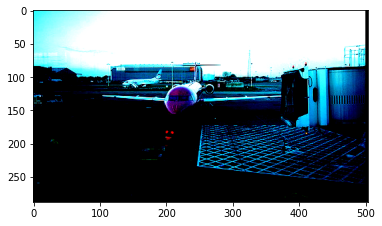

In [211]:
temp = np.array(img)[0,:,:]
plt.imshow(temp.transpose(1,2,0))

1.0 0.0 121948


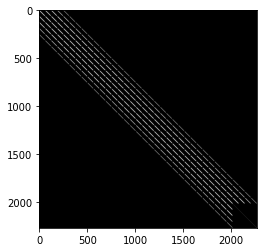

In [221]:
temp0 = model.forward(img.cuda(), True).cpu().detach().numpy()
plt.imshow(temp0, cmap='gray')
print(temp0.max(), temp0.min(), np.count_nonzero(temp0))

In [222]:
cam_vec.shape, cam_vec.max(), cam_vec.min()

(torch.Size([21, 2268]), tensor(1.0239), tensor(-0.0103))

In [214]:
cam_rw.shape, cam_rw.max(), cam_rw.min()

(torch.Size([1, 21, 288, 504]),
 tensor(0.1427, device='cuda:0'),
 tensor(-9.9999e-06, device='cuda:0'))

In [215]:
cam_rw.cpu().max(), cam_rw.cpu().min()

(tensor(0.1427), tensor(-9.9999e-06))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


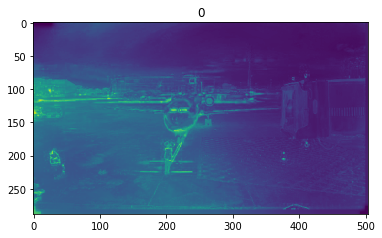

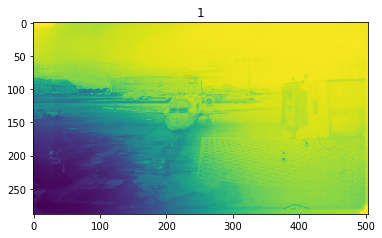

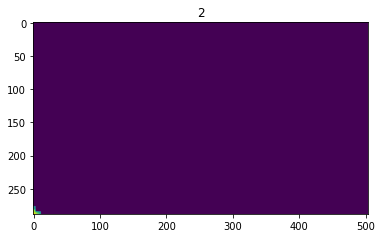

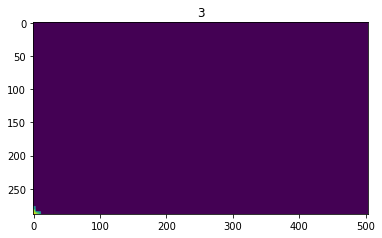

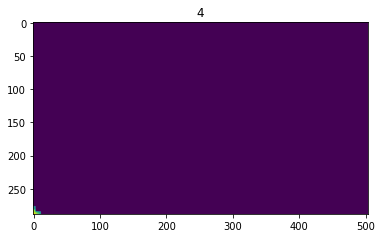

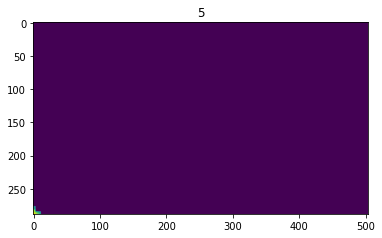

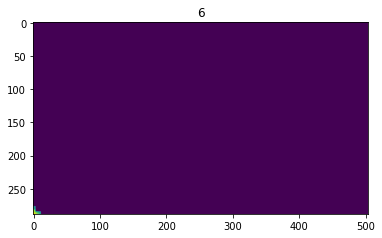

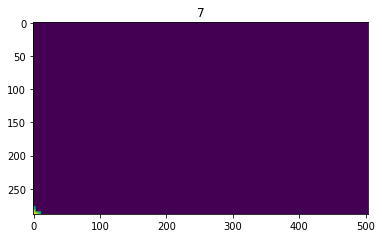

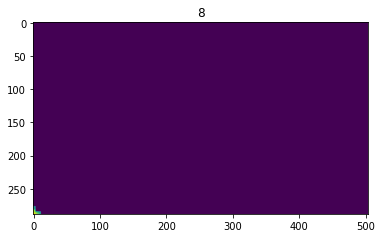

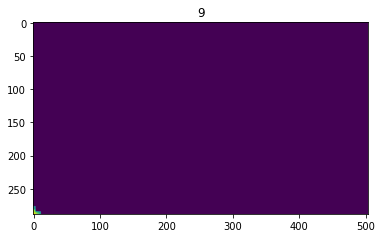

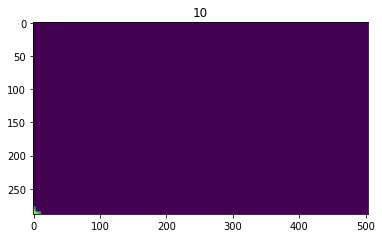

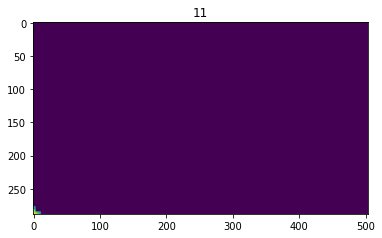

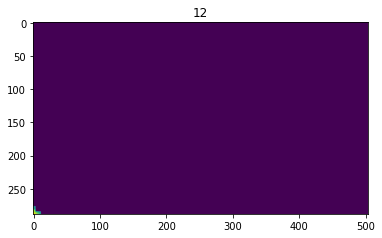

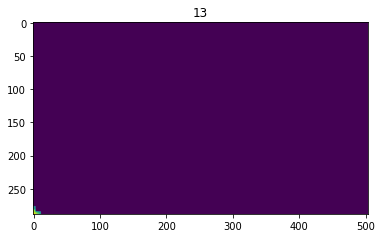

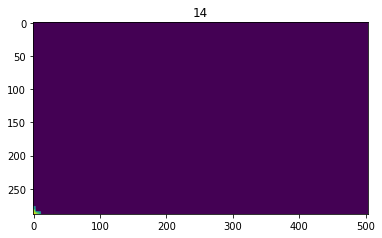

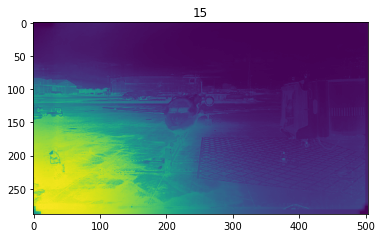

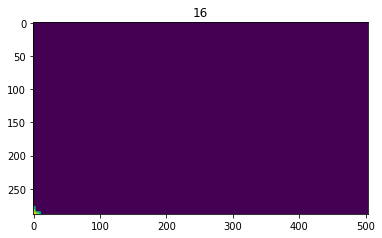

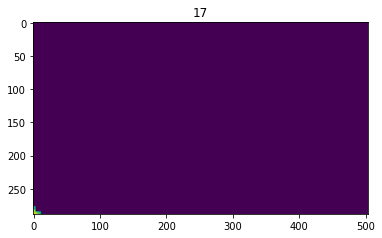

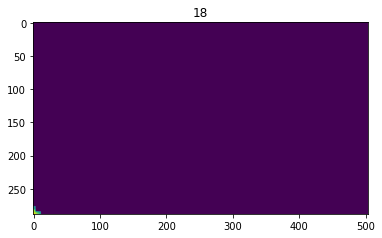

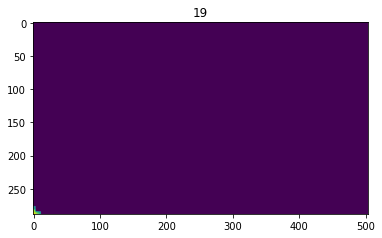

In [239]:
temp = np.array(cam_rw.cpu())[0,:,:]

for i in range(20):
  print(i)
  plt.figure()
  plt.imshow(temp.transpose(1,2,0)[:,:,i])
  plt.title(i)

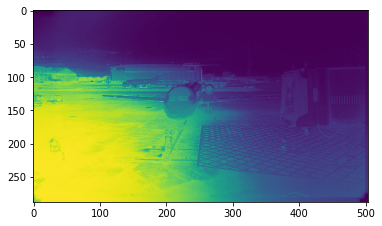

In [234]:
temp = np.array(cam_rw.cpu())[0,:,:]
plt.imshow(temp.transpose(1,2,0)[:,:,15])

In [242]:
temp.transpose(1,2,0)[:,:,0].max()

0.13528684

In [198]:
cam

{0: array([[ 7.7288221e-03,  7.6696705e-03,  7.6450706e-03, ...,
          1.0630650e-03,  1.0679924e-03,  1.0798393e-03],
        [ 7.6948530e-03,  7.6358290e-03,  7.6112808e-03, ...,
          1.0594665e-03,  1.0643944e-03,  1.0762421e-03],
        [ 7.7442406e-03,  7.6850322e-03,  7.6604076e-03, ...,
          1.0646983e-03,  1.0696256e-03,  1.0814723e-03],
        ...,
        [-9.9999006e-06, -9.9999006e-06, -9.9999006e-06, ...,
          4.6519022e-03,  4.6781283e-03,  4.7411821e-03],
        [-9.9999006e-06, -9.9999006e-06, -9.9999006e-06, ...,
          4.6414183e-03,  4.6676337e-03,  4.7306623e-03],
        [-9.9999006e-06, -9.9999006e-06, -9.9999006e-06, ...,
          4.6486296e-03,  4.6748524e-03,  4.7378987e-03]], dtype=float32),
 14: array([[-9.999901e-06, -9.999901e-06, -9.999901e-06, ..., -9.999901e-06,
         -9.999901e-06, -9.999901e-06],
        [-9.999901e-06, -9.999901e-06, -9.999901e-06, ..., -9.999901e-06,
         -9.999901e-06, -9.999901e-06],
        [-9.999

In [192]:
cam_rw.cpu().min()

tensor(-9.9999e-06)

In [193]:
temp2, cam_rw_pred = torch.max(cam_rw, 1)

In [194]:
np.unique(np.array(cam_rw_pred.cpu()))

array([0])

In [40]:
cam_full_arr.max(), cam_full_arr.min(), cam_full_arr.shape

(tensor(1.0239), tensor(-0.0103), torch.Size([21, 36, 63]))

In [36]:
cam_rw.shape, cam_rw.max()

(torch.Size([1, 21, 288, 504]), tensor(1., device='cuda:0'))

In [197]:
cam_full_arr[14].min(), cam[14].max()

(tensor(0.), 1.0486801)

In [196]:
cam_rw_pred.shape

torch.Size([1, 288, 504])

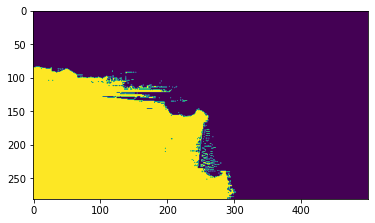

In [235]:
plt.imshow(res)

# run .py script

In [ ]:
# !python ./scripts/infer.py \
#     --img_dir=/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2 \
#     --infer_list=./kvasirv2/val.txt \
#     --batch_size=32 \
#     --dataset=kvasir \
#     --input_size=256 \
# 	  --num_classes=8 \
#     --restore_from=./checkpoints/train/exp4/kvasir_epoch_13.pth \
#     --save_dir=./results_kvasir/exp4/attention/ \
#     --out_cam=./results_kvasir/exp4/results_cam \
#     --out_crf=./results_kvasir/exp4/results_crf \